## Long Short Term Memory network (LSTM)

### Para predição de séries temporais

O dataset utilizado descreve a quantidade de vendas mensais de um shampoo ao longo de um período de 3 anos

*Baseado em exemplo por Jason Brownlee*

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


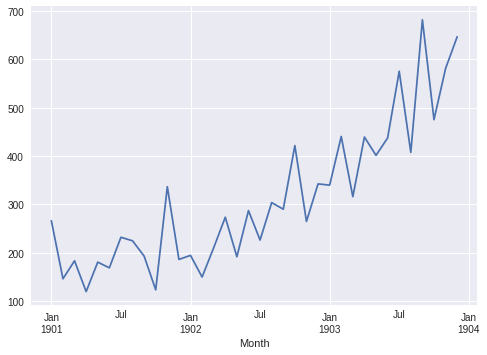

In [1]:
# carrega e plota dataset
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt

# carrega dataset a partir de um parser pelos dados
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# obtem os dados a partir de arquivo CSV
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# exibe as primeiras linhas
print(series.head())
# plota a série temporal
series.plot()
plt.show()

Vamos dividir a série em duas partes: treinamento e teste: os dois primeiros anos serão usados para treinamento e o terceiro para teste.

In [0]:
# exemplo de divisão em treinamento/teste
X = series.values
train, test = X[0:-12], X[-12:]

O cenário de predição móvel será considerado (do inglês *walk forward model validation*)

Cada passo do dataset de testes será percorrido um por um. Um modelo será utilizado para predizer um dado ponto no tempo, o qual será disponibilizado e utilizado para predizer os próximos pontos.

A idéia é imitar um cenário real em que as observações de vendas são disponíveis a cada mês e utilizadas para predizer o próximo mês.

Após obter todas as predições, então iremos comparar utilizando a métrica RMSE (Root Mean Squared Error), obtida da biblioteca `sklearn` no formato:

`from sklearn.metrics import mean_squared_error`

`rmse = sqrt(mean_squared_error(test, predictions))`

`print('RMSE: %.3f' % rmse)`

**Abaixo, vamos simular um tipo de predição utilizando apenas o valor anterior, para entender o processo de prediçao**

RMSE: 136.761


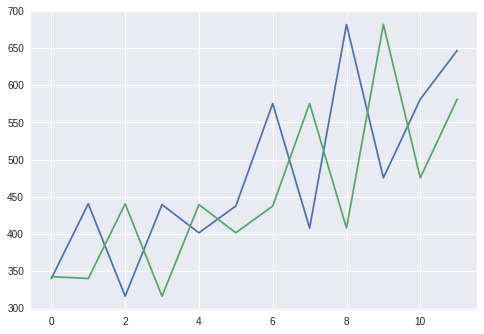

In [0]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# carrega dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', 
                  header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

## Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Para isso precisaremos:
1. Transformar a série temporal em um problema de aprendizado supervisionado (e.g. f(x) = y)
2. Transformar os dados da série temporal de forma que seja estacionária
3. Transformar as observações para uma escala específica

### Parte 1: Problema de aprendizado supervisionado
Podemos cumprir essa etapa utilizando a observação do último passo $t-1$ como entrada e a observação atual $t$ como saída.

Podemos alcançar isso utilizando a função `shift()` do Pandas que irão empurrar todos os valores da série por um número específico de posições. Aqui vamos deslocar 1 posição para trás, que se tornarão as variáveis de entrada, sendo que a série temporal original será considerada como a variável de saída.

A função abaixo permite fazer essa operação

In [0]:
from pandas import DataFrame
from pandas import concat

# modifica uma serie temporal tornando-a
# um problema de aprendizado supervisionado
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [0]:
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


### Parte 2 - tornando a série estacionária

Os dados como estão não são estacionários, devido à tendência (*trend*) que torna-os incrementalmente maiores ao longo do tempo. Essa tendência pode ser removida, facilitando processar os dados e posteriormente re-adicionada para reconstruir a série.

Uma forma bastante utilizada de remover a tendência é diferenciar os dados - na prática fazer a subtração entre a observação anterior e a atual.

Para isso usamos a função `diff()` disponível na biblioteca `pandas`

A função abaixo calcula essa diferenciação, iniciando na posição 1 (pulamos a zero pois não há observação anterior a ela)

In [0]:
from pandas import Series

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

Para permitir inverter posteriormente, criamos uma função para esse fim

In [0]:
# inverte o valor diferenciado, somando de volta
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

Vamos testar essas funções

In [0]:
# série antes da transformação
print(series[:6])
# transforma os dados em estacionários e imprime
differenced = difference(series, 1)
print(differenced.head())
# inverte e imprime
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


### Parte 3 - escalando a série temporal

LSTMs esperam que os dados estejam num certo intervalo.
Esse intervalo é comumente relacionado à função de ativação utilizada.

Nas redes recorrentes é padrão o uso da tangente hiperbólica, que compata os valores no intervalo $[-1, 1]$

De forma a executar um experimento sem deixar que os dados de teste sejam utilizados, calculamos o intervalo mínimo e máximo *apenas no treinamento* e aplicamos a escala calculada em todos os dados futuros (teste e predições).

Para a transformação, usamos a classe `MinMaxScaler` da biblioteca `sklearn`, conforme o exemplo abaixo

Note que depois temos que considerar inverter a escala, para que os dados finais estejam na escala original.

In [0]:
from sklearn.preprocessing import MinMaxScaler

# serie original 
print(series[:5])

# transformação de escala
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# inversão, para que a escala seja a original
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
Name: Sales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


Definindo funções para realizar escala e inversão:

In [0]:
# escala dados para [-1, 1]
def scale(train, test):
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverte escala
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

## Rede LSTM

Uma camada LSTM espera como entrada uma matriz com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.

Dado que o conjunto de treinamento é definido como $X$ entradas e $y$ saídas, precisamos re-modelar a base de dados no formato correto conforme os parâmetros *samples*, *time_steps* e *features*, em algo como

`X, y = train[:, 0:-1], train[:, -1]`

`X = X.reshape(X.shape[0], 1, X.shape[1])`

O tamanho dos dados de entrada (dimensões da matriz) devem ser especificadas ao criar a camada LSTM, com base no argumento *batch_input_shape* - o número de observações em cada batch, o número de time steps e features.

Além disso, definimos o número de neurônios, ou seja a quantidade de unidades de memória, ex. 1 a 5.

A linha abaixo cria uma única camada LSTM 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

neurons = 2
batch_size = 5
layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)

Montando uma rede completa, temos:

In [0]:
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


Algo importante para considerar é que, o Keras, por padrão embaralha as observações antes de fornecê-las para a rede. Nesse caso não desejamos isso pois a sequência é importante. Para isso setamos o argumento `shuffle=False`

Podemos então resetar o estado interno no final de cada época, tornando-o pronto para a próxima iteração. Dados todos esses detalhes, vamos construir uma função para treinamento da rede LSTM

In [0]:
def fit_lstm(train, batch_size, no_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(no_epoch):
    # treinamos com batch=1 por vez devido a organizacao dos dados
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

## Predição 
Após treinado o modelo podemos definir uma função que realiza a predição ponto a ponto. A partir da função `predict` disponível no Keras, iremos re-modelar a entrada e selecionar apenas um valor por vez.

In [0]:
def forecast(model, batch_size, row):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

## Utilizando as funções

Repassando todos os passos, agora redefinindo as funções e após utilizando-as de forma a obter o resultado desejado

In [0]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

def scale(train, test):
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

def fit_lstm(train, batch_size, no_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(no_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


Month=1, Predicted=230.479891, Expected=339.700000
Month=2, Predicted=337.010313, Expected=440.400000
Month=3, Predicted=327.635984, Expected=315.900000
Month=4, Predicted=406.790274, Expected=439.300000
Month=5, Predicted=258.935886, Expected=401.300000
Month=6, Predicted=414.721059, Expected=437.400000
Month=7, Predicted=438.123476, Expected=575.500000
Month=8, Predicted=406.351356, Expected=407.600000
Month=9, Predicted=484.198235, Expected=682.000000
Month=10, Predicted=374.766489, Expected=475.300000
Month=11, Predicted=536.885133, Expected=581.300000
Month=12, Predicted=325.133208, Expected=646.900000
Test RMSE: 134.848


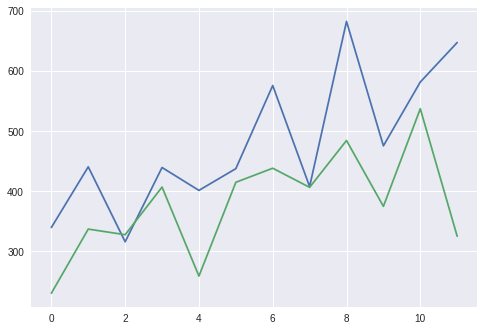

In [0]:
# carrega dados
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv',
                  header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transformação para estacionário
raw_values = series.values
diff_values = difference(raw_values, 1)

# transformação no formato de aprendizado supervisionado
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# partição dos dados em treinamento e teste
train, test = supervised_values[0:-12], supervised_values[-12:]

# transformação na escala -1 a 1
scaler, train_scaled, test_scaled = scale(train, test)

# treinamento do modelo (3000 épocas, 3 neurônios)
lstm_model = fit_lstm(train_scaled, 1, 3000, 3)

# predição do dataset completo para iniciar
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation nos dados de teste
predictions = list()
for i in range(len(test_scaled)):
	# realiza a prediçao de um passo
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# inverte  a escala
	yhat = invert_scale(scaler, X, yhat)
	# inverte diferenciação
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# armazena predição
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# analisa performance com base no RMSE
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# gráfico dos valores observados vs preditos
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()